# 1. Import Dependencies

In [82]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
import matplotlib.pyplot as plt

# 2. MediaPipe Hands Functions

In [13]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

In [14]:
def mp_process(image_bgr, mp_model):
    image_bgr.flags.writeable = False
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    mp_outputs = mp_model.process(image_rgb)
    image_bgr.flags.writeable = True
    return mp_outputs

In [15]:
def draw_mp_hands_landmarks(image_bgr, mp_hands_outputs):
    if mp_hands_outputs.multi_hand_landmarks:
        image_drawn_landmarks = image_bgr
        for hand_landmarks in mp_hands_outputs.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image_drawn_landmarks,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                None,
                mp_drawing.DrawingSpec(color=(255, 255, 255))
            )

        return image_drawn_landmarks
    else:
        return image_bgr

## Demonstration

In [39]:
cap = cv2.VideoCapture(0)

with mp_hands.Hands(max_num_hands=1) as hands:
    while cap.isOpened():
        success, image_bgr = cap.read()
        
        mp_hands_outputs = mp_process(image_bgr, hands)
        
        image_drawn_landmarks = draw_mp_hands_landmarks(image_bgr, mp_hands_outputs)
        
        cv2.imshow('OpenCV Feed', cv2.flip(image_drawn_landmarks, 1))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

# 3. Extract MediaPipe Landmarks

In [20]:
def get_mp_hands_landmarks(mp_hands_outputs):
    if mp_hands_outputs.multi_hand_landmarks:
        mp_hands_landmarks = np.array([
            [values.x, values.y, values.z] for values in mp_hands_outputs.multi_hand_landmarks[0].landmark
        ]).flatten()
    else:
        mp_hands_landmarks = np.zeros(63)

    return mp_hands_landmarks

In [21]:
test = get_mp_hands_landmarks(mp_hands_outputs)

In [22]:
test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# 4. Setup Folders for Collection

In [23]:
data_path = os.path.join('MediaPipeData')

actions = np.array(['A', 'B', 'C'])

n_sequences = 30

sequence_len = 30

In [37]:
for action in actions:
    for sequence in range(n_sequences):
        if not os.path.exists(f'{data_path}/{action}/{str(sequence)}'):
            os.makedirs(os.path.join(data_path, action, str(sequence)))

# 5. Collect Data for Training and Testing

In [40]:
cap = cv2.VideoCapture(0)

with mp_hands.Hands(max_num_hands=1) as hands:
    for action in actions:
        for sequence in range(n_sequences):
            for frame_num in range(sequence_len):
                
                success, image_bgr = cap.read()

                mp_hands_outputs = mp_process(image_bgr, hands)

                image_drawn_landmarks = draw_mp_hands_landmarks(image_bgr, mp_hands_outputs)
                
                if frame_num == 0:
                    image = cv2.putText(
                        cv2.flip(image_drawn_landmarks, 1),
                        'Starting Collection',
                        (120, 200),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 255, 0),
                        4,
                        cv2.LINE_AA
                    )
                    
                    image = cv2.putText(
                        image,
                        f'Collecting frames for "{action}" - Video number {sequence}',
                        (15, 12),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 0, 255),
                        1,
                        cv2.LINE_AA
                    )
                    
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    image = cv2.putText(
                        cv2.flip(image_drawn_landmarks, 1),
                        f'Collecting frames for "{action}" - Video number {sequence}',
                        (15, 12),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 0, 255),
                        1,
                        cv2.LINE_AA
                    )
                    
                    cv2.imshow('OpenCV Feed', image)
                
                mp_hands_landmarks = get_mp_hands_landmarks(mp_hands_outputs)
                np_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(np_path, mp_hands_landmarks)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()

In [36]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [42]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [43]:
label_map = {label: num for num, label in enumerate(actions)}

In [44]:
label_map

{'A': 0, 'B': 1, 'C': 2}

In [45]:
sequences, labels = [], []
for action in actions:
    for sequence in range(n_sequences):
        window = []
        for frame_num in range(sequence_len):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [46]:
X = np.array(sequences)

In [47]:
X.shape

(90, 30, 63)

In [48]:
y = to_categorical(labels).astype(int)

In [49]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [51]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [53]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [70]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 63)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [56]:
res = [0.7, 0.2, 0.1]

In [57]:
actions[np.argmax(res)]

'A'

In [71]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [59]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 5s 230ms/step - loss: 1.0995 - categorical_accuracy: 0.3176
Epoch 2/2000
3/3 [==============================] - 1s 223ms/step - loss: 1.0985 - categorical_accuracy: 0.3294
Epoch 3/2000
3/3 [==============================] - 1s 218ms/step - loss: 1.0925 - categorical_accuracy: 0.3412
Epoch 4/2000
3/3 [==============================] - 1s 213ms/step - loss: 1.0853 - categorical_accuracy: 0.3765
Epoch 5/2000
3/3 [==============================] - 1s 191ms/step - loss: 1.0696 - categorical_accuracy: 0.4824
Epoch 6/2000
3/3 [==============================] - 1s 194ms/step - loss: 1.0371 - categorical_accuracy: 0.4824
Epoch 7/2000
3/3 [==============================] - 1s 214ms/step - loss: 0.9289 - categorical_accuracy: 0.6235
Epoch 8/2000
3/3 [==============================] - 1s 191ms/step - loss: 0.9016 - categorical_accuracy: 0.7059
Epoch 9/2000
3/3 [==============================] - 1s 221ms/step - loss: 0.8155 - categorical_accuracy:

KeyboardInterrupt: 

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            32768     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 187,331
Trainable params: 187,331
Non-tr

# 8. Make Predictions

In [61]:
res = model.predict(X_test)

1/1 [==============================] - 1s 578ms/step


In [64]:
np.argmax(res[0])

1

In [62]:
actions[np.argmax(res[4])]

'C'

In [65]:
y_test

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [67]:
actions[np.argmax(y_test[1])]

'A'

# 9. Save Weights

In [68]:
model.save('abc.h5')

In [69]:
del model

In [72]:
# Rebuild, compile and load

model.load_weights('abc.h5')

# 10. Evaluation Using Confusing Matrix and Accuracy

In [73]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [78]:
yhat = model.predict(X_test)

3/3 [==============================] - 0s 53ms/step


In [79]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [80]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[57,  0],
        [ 0, 28]],

       [[56,  0],
        [ 0, 29]],

       [[57,  0],
        [ 0, 28]]], dtype=int64)

In [81]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [86]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
    return output_frame

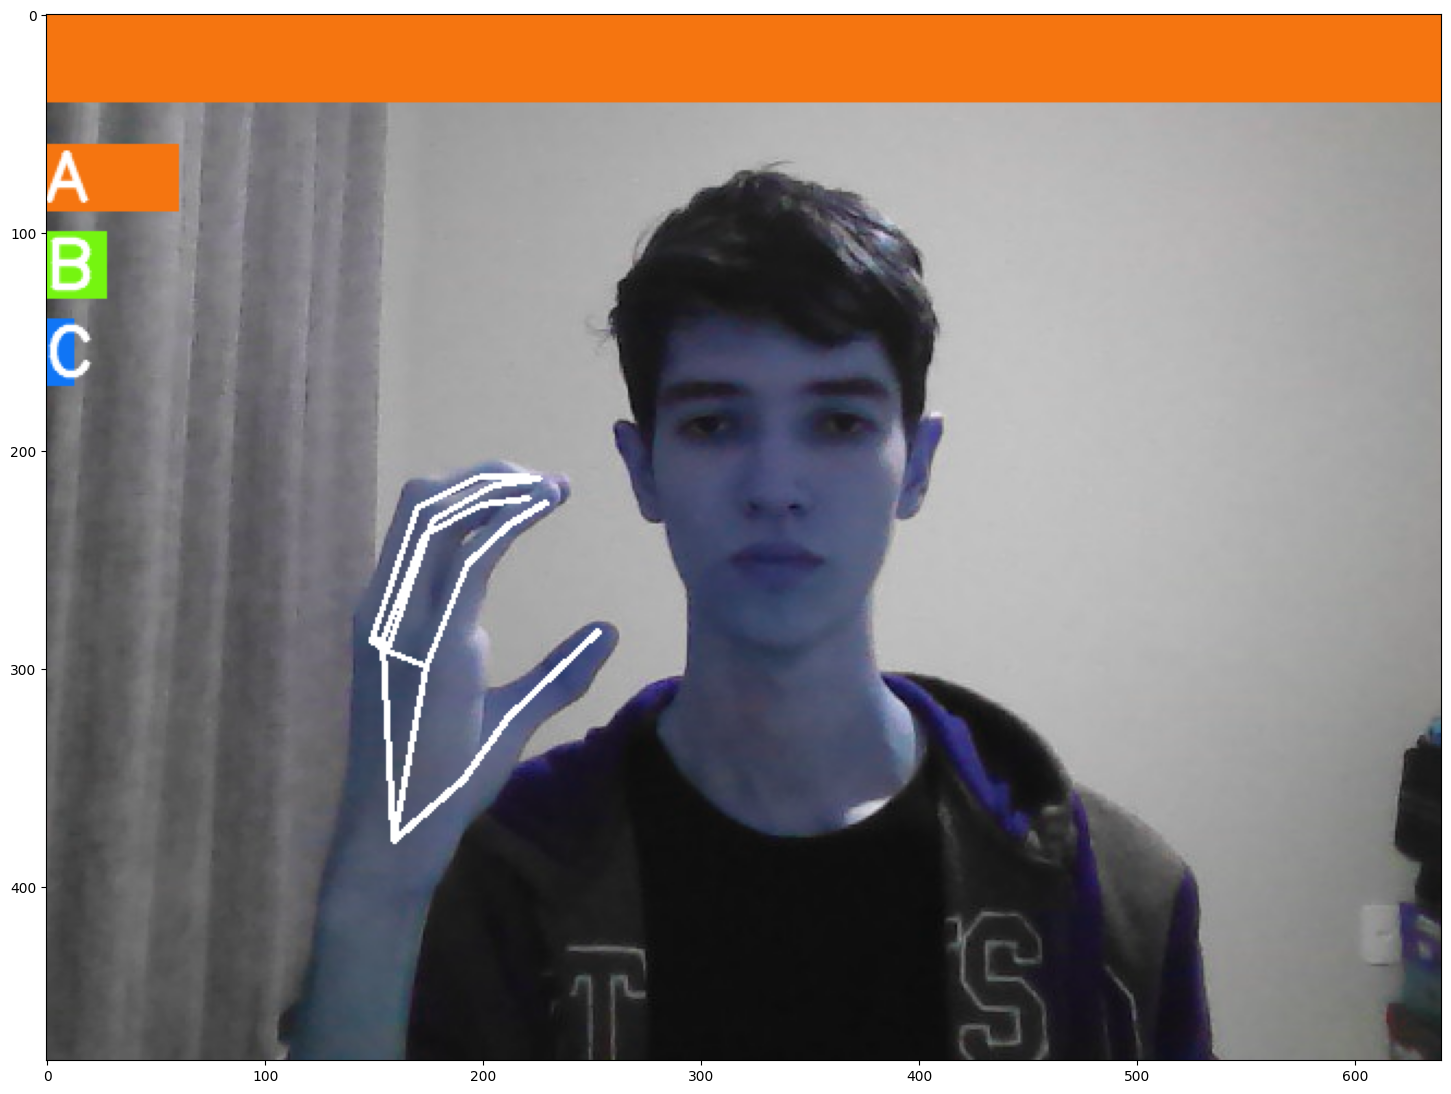

In [87]:
plt.figure(figsize=(18, 18))
plt.imshow(prob_viz(res, actions, image, colors))

In [88]:
sequence.reverse()

In [89]:
len(sequence)

30

In [93]:
sequence = []
sentence = []
threshold = 0.4

cap = cv2.VideoCapture(0)

with mp_hands.Hands(max_num_hands=1) as hands:
    while cap.isOpened():
        success, image_bgr = cap.read()
        
        mp_hands_outputs = mp_process(image_bgr, hands)
        
        image_drawn_landmarks = draw_mp_hands_landmarks(image_bgr, mp_hands_outputs)
        
        mp_hands_landmarks = get_mp_hands_landmarks(mp_hands_outputs)
        sequence.append(mp_hands_landmarks)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
        
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
                
            image = prob_viz(res, actions, cv2.flip(image_drawn_landmarks, 1), colors)
            
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 61ms/step


In [85]:
cap.release()
cv2.destroyAllWindows()